# Download data

In [88]:
from download_file import *

In [2]:
url = "https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip"
download_dir = '..//..//datasets_collection//Traffic_Sign_Classifier'
maybe_download_and_extract(url, download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


# importing some useful packages

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
%matplotlib inline
import tensorflow as tf
from PIL import Image
import time
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

D:\Anaconda_36\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers

Using TensorFlow backend.


In [433]:
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from IPython.display import clear_output, Image, display, HTML
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import math
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

# Read data

In [452]:
def read_data_sets(file):
    """
    Load pickled data
    args:
        file   (str)     path to datasets 
    yields:
        features and label of datasets (numpy array)
    """
    with open(file, mode='rb') as f:
        return pickle.load(f)

In [454]:
# Load pickled data
import pickle

data_rel_path = "..\\..\\datasets_collection\\Traffic_Sign_Classifier"
# the data augmentation was done in another notebook: Data aumentation.ipynb

train = read_data_sets(os.path.join(data_rel_path, "aug_train_600.p"))
valid= read_data_sets(os.path.join(data_rel_path, "valid.p")) 
test = read_data_sets(os.path.join(data_rel_path, "test.p")) 

    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [455]:
data_pd = pd.read_csv(os.path.join(data_rel_path, 'signnames.csv'))

# Dataset Exploration

## Dataset Summary

In [458]:
n_train = len(y_train)
n_test = len(y_test)
image_shape = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 41469
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Exploratory Visualization

In [459]:
def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()
def plot_random_1C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot],cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()   
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(pre_process_image(X[ind_plot]),cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

### original images

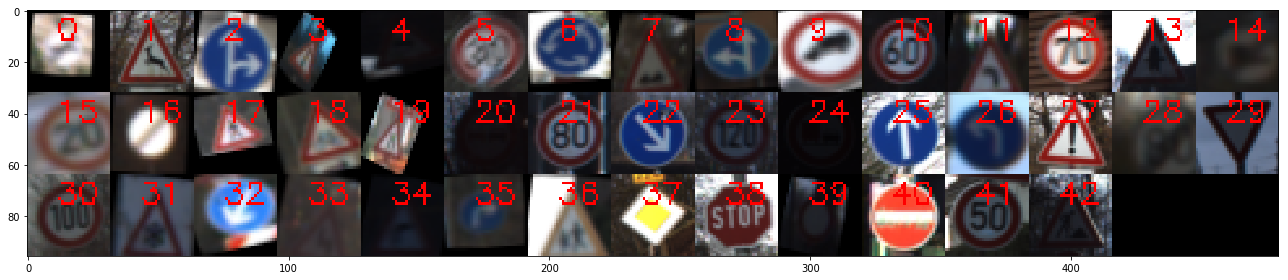

In [460]:
# plot_random_3C(4,4,X_train,y_train)
import scipy.misc as sm
def plot_label_image(file):
    image_every_class=dict()
    for im,cl in zip(train['features'],train['labels']):
        image_every_class[cl]=im

    image_every_class=list(image_every_class.values()) # each images represent a image of the class 

    cols=15
    rows=1+len(image_every_class)//cols
    n_classes = len(image_every_class) # 43
    image_padding = n_classes%cols
    
    for y in range(rows):
        if y==rows-1: #last row
            img_last=np.concatenate(image_every_class[-image_padding:],axis=1)
            img_empty=np.zeros((32, 32*(cols - image_padding), 3))
            img_row=np.concatenate((img_last, img_empty),axis=1)
        else:
            img_row=np.concatenate(image_every_class[y*cols:(y+1)*cols],axis=1)        
        if y==0:
            image=img_row
        else:
            image=np.concatenate((image,img_row),axis=0) 

    # add class number
    for y in range(0,1+int(len(image_every_class)/cols)):
        for x in range(cols):
            if(x+y*cols<n_classes):
                cv2.putText(image,str(x+y*cols),(11+x*32,11+y*32), cv2.FONT_HERSHEY_SIMPLEX, 0.4,(255,0,0),1,cv2.LINE_AA)
#     # resize image
    fig, ax = plt.subplots(figsize=(18, 4))
    c =sm.imresize(image,(image.shape[0],image.shape[1]))
    ax.imshow(c, aspect='auto')
    plt.tight_layout() 
    
plot_label_image(train)

### frequency table of training set

In [464]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [465]:
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0])
data_pd_sorted = data_pd_sorted.reindex(data_pd_sorted["ClassId"])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0])
data_pd_sorted = data_pd_sorted.drop(['ClassId'], axis = 1)

In [466]:
data_pd_sorted

,SignName,Occurance
2,Speed limit (50km/h),2010
1,Speed limit (30km/h),1980
13,Yield,1920
12,Priority road,1890
38,Keep right,1860
10,No passing for vehicles over 3.5 metric tons,1800
4,Speed limit (70km/h),1770
5,Speed limit (80km/h),1650
25,Road work,1350
9,No passing,1320


## bar chart of training set

<Container object of 43 artists>

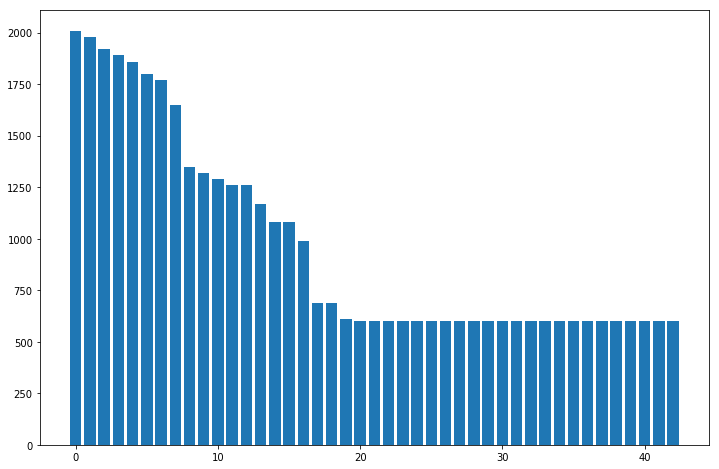

In [467]:
plt.figure(figsize=(12,8))
plt.bar(range(43),height=data_pd_sorted["Occurance"])

# Design and Test a Model Architecture

## Preprocessing

### histogram equalization: 
* reason: The contrast of brightness will be enhanced.

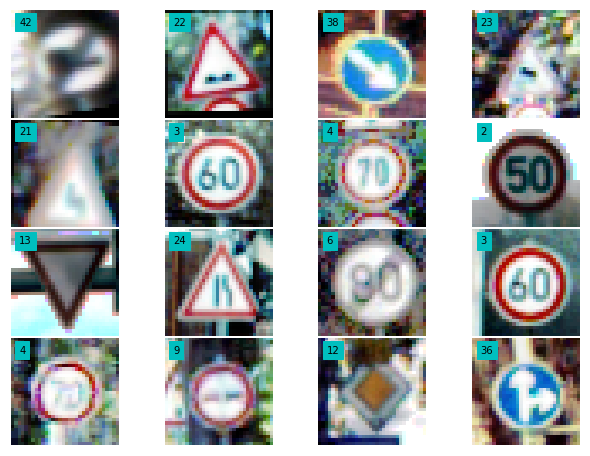

In [472]:
def pre_process_image(image):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    return image

img_resize = 32
N_classes = 43
image_shape = (img_resize,img_resize)
img_size_flat = img_resize*img_resize

image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

plot_random_3C(4,4,image_GS_train+.5,y_train)

In [468]:
img_size = 30

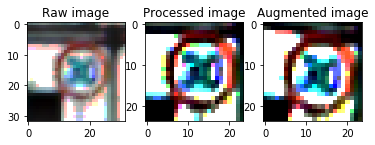

Final image size is (24, 24, 3)


In [469]:
#Some useful image functions
  
def show3img(img, img1, img2):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.title("Augmented image")
    plt.show()
    
def eq_Hist(img):
    #Histogram Equalization
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img):
    img2=sharpen_img(img)
    img2=crop(img2,3)
    img2=contr_img(img2, 1.5)
    return eq_Hist(img2)

def augment_img(img):
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img)

x_selected = X_train[y_train == 1]
im=x_selected[60, :, :, :]
imp=contr_img(im, 0.5)

show3img(im, transform_img(im), augment_img(im))
print("Final image size is", transform_img(im).shape)

In [470]:
X_train_equalize = list()
X_test_equalize = list()
X_valid_equalize = list()

for i in range(len(X_train)):
    X_train_equalize.append(transform_img(X_train[i]))
for i in range(len(X_test)):
    X_test_equalize.append(transform_img(X_test[i]))    
for i in range(len(X_valid)):
    X_valid_equalize.append(transform_img(X_valid[i]))

In [471]:
X_train_equalize = np.array(X_train_equalize)
X_test_equalize = np.array(X_test_equalize)
X_valid_equalize = np.array(X_valid_equalize)

### normalization: 
* reason: improve learninig speed
* method: scaled images between -.5 and .5, by dividing by 255. and subtracting .5.

In [16]:
X_train_norm = X_train_equalize/255.
X_test_norm = X_test_equalize/255.
X_valid_norm = X_valid_equalize/255.

### One hot encoding

In [ ]:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')


In [473]:
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)
labels_valid = OHE_labels(y_valid,43)

check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

One hot encoding correct, ok to proceed
One hot encoding correct, ok to proceed


### data augmentation (Keras version): 

* Because of limited data and the class imbalance, additional data was generated by affine transformation including 
    1. **rotation** with random number generated between +/- 15 degress
    2. **translation** by +/- 10 pixels along vertical and horizontal direction
    3. **shearing**

In [78]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(X_train_norm)

## Model

### Model Architechture

In [42]:
def create_model(baseMapNum = 32, weight_decay = 1e-4, num_classes = 43):    
    model = Sequential()
    # 1: convolution: kernel size 3x3
    model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train_norm.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 2: maxpool: kernel size 2x2
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    # 3: convolution: kernel size 3x3
    model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 4: maxpool: kernel size 2x2
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    
    # 5: convolution: kernel size 3x3
    model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 6: maxpool: kernel size 2x2
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    # 7: fully-connected layter 256
    model.add(Dense(256))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    # 8: fully-connected layter 128
    model.add(Dense(128))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    # 9: fully-connected layter 43
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model


In [21]:
model = create_model(baseMapNum = 32, weight_decay = 1e-4, num_classes = 43)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 12, 64)        256       
__________

### Training the model

In [23]:
from keras.optimizers import Adam

In [24]:
opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics=['accuracy'])

In [25]:
history = model.fit(X_train_norm, labels_train,
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test_norm, labels_test),
                  verbose=1,
                  shuffle=True)    


Train on 41469 samples, validate on 12630 samples
Epoch 1/10
41469/41469 [==============================] - 98s 2ms/step - loss: 1.8949 - acc: 0.4456 - val_loss: 0.8899 - val_acc: 0.7343
Epoch 2/10
41469/41469 [==============================] - 117s 3ms/step - loss: 0.7907 - acc: 0.7515 - val_loss: 0.5148 - val_acc: 0.8529
Epoch 3/10
41469/41469 [==============================] - 117s 3ms/step - loss: 0.5693 - acc: 0.8281 - val_loss: 0.4431 - val_acc: 0.8767
Epoch 4/10
41469/41469 [==============================] - 128s 3ms/step - loss: 0.4601 - acc: 0.8625 - val_loss: 0.4125 - val_acc: 0.8873
Epoch 5/10
41469/41469 [==============================] - 151s 4ms/step - loss: 0.3971 - acc: 0.8842 - val_loss: 0.3762 - val_acc: 0.8974
Epoch 6/10
41469/41469 [==============================] - 138s 3ms/step - loss: 0.3579 - acc: 0.8985 - val_loss: 0.3495 - val_acc: 0.9043
Epoch 7/10
41469/41469 [==============================] - 121s 3ms/step - loss: 0.3272 - acc: 0.9080 - val_loss: 0.3630 - v

In [193]:
model.save_weights('model//keras_german_sign_ADAM_weighted_93_2.h5')

# Restore model and continue training

The computation resource on local machine is based on CPU. To accelerate the model training, GPU on AWS EC2 was used to train the model. The main training par is in **model_ec2.ipynb**

In [43]:
from keras.models import load_model
# load_weights only sets the weights of your network. You still need to define its architecture before calling load_weights

In [426]:
model2 = create_model()

In [427]:
model2.load_weights('model//EC2_model//keras_german_sign_ADAM_weighted_93_2.h5')

In [428]:
opt_adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.000001)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics=['accuracy'])

In [429]:
while history.history["val_acc"] < 0.93:
    history = model2.fit(X_train_norm, labels_train,
              batch_size=64,
              epochs=1,
              validation_data=(X_test_norm, labels_test),
              verbose=1,
              shuffle=True)    

Train on 41469 samples, validate on 12630 samples
Epoch 1/1
41469/41469 [==============================] - 129s 3ms/step - loss: 0.0854 - acc: 0.9784 - val_loss: 0.3601 - val_acc: 0.9350


## History log of accuracy and loss

In [431]:
history.history

{'acc': [0.97841761315537856],
 'loss': [0.085400907384434843],
 'val_acc': [0.93499604116237456],
 'val_loss': [0.36014783016198793]}

# Test on testing set

In [51]:
scores = model2.evaluate(X_valid_norm, labels_valid, batch_size=64, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

4410/4410 [==============================] - 5s 1ms/step

Test result: 93.016 loss: 0.401


# Test images on the Internet

In [260]:
SignName = np.array(data_pd_sorted.sort_index()["SignName"])

## preprocess test images

In [269]:
test_images_path = 'test_images'
new_test_images = []
new_test_labels = []

for i in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path,i))   
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_labels.append(i.split(".")[0])
    new_test_images.append(img)

In [270]:
new_test_images = np.array(new_test_images)
new_test_labels = np.array(new_test_labels)
print (new_test_images.shape)
print (new_test_labels.shape)

(10, 32, 32, 3)
(10,)


In [279]:
new_test_images_equalize = []
for i in range(len(new_test_images)):
    new_test_images_equalize.append(transform_img(new_test_images[i]))

In [284]:
new_test_images_equalize = np.array(new_test_images_equalize)
new_test_images_X = new_test_images_equalize/255.
new_test_images_Y = OHE_labels(new_test_labels,43)

In [286]:
scores = model2.evaluate(new_test_images_X, new_test_images_Y, batch_size=64, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10/10 [==============================] - 0s 47ms/step

Test result: 100.000 loss: 0.012


In [288]:
y_pred = model2.predict(new_test_images_X, batch_size=64, verbose=1)

10/10 [==============================] - 0s 33ms/step


## Plot top 5 predition

For each of the new images, the model's softmax probabilities were printed out to show the **certainty** of the model's predictions based on the output of the top 5 probabilities for each image).

`tf.nn.top_k` will return the **values** and **indices** (class ids) of the top k predictions. So if k=5, for each sign, it'll return the top 5 largest probabilities (out of a possible 43) and the correspoding class ids.

In [420]:
def plot_top_k_predition(plot_cache, k):
    """
    get top 5 probabilities from model
    access to the predition probability with top_5_pred.values and indices with top_5_pred.indices
    """
    output = tf.nn.top_k(plot_cache["label_pred"], k)
    top_k_pred = 0
    with tf.Session() as sess:
        top_k_pred = sess.run(output)
        
    label_list = [data_pd_sorted.loc[j].SignName.tolist() for j in top_k_pred.indices]
    
    plt.figure(figsize=(25, 30))
    m = len(plot_cache["feature"])
    x= 10
    y= 20
    row_img_num = 2
    for i in range(m):
        plt.subplot(m, row_img_num, row_img_num*i+1)  # (row_n, column_n, index)
        plt.imshow(plot_cache["test_images"][i]) 
        plt.title(plot_cache["title"][i])
        plt.axis('off')
        
        ind = np.arange(5)  # the x locations for the groups
        width = 0.35       # the width of the bars
        plt.subplot(m, row_img_num, row_img_num*i+2)
        
        rects = plt.barh(np.arange(1, 6, 1), top_k_pred.values[i])
        
        plt.yticks(np.arange(1, 6, 1), label_list[i])
        for i in range(len(rects)):
            plt.text(1, i+1, rects[i].get_width(), ha='right', va='center')
        
    plt.show()

In [421]:
new_test_title = {i: SignName[i] for i in range(len(SignName))}

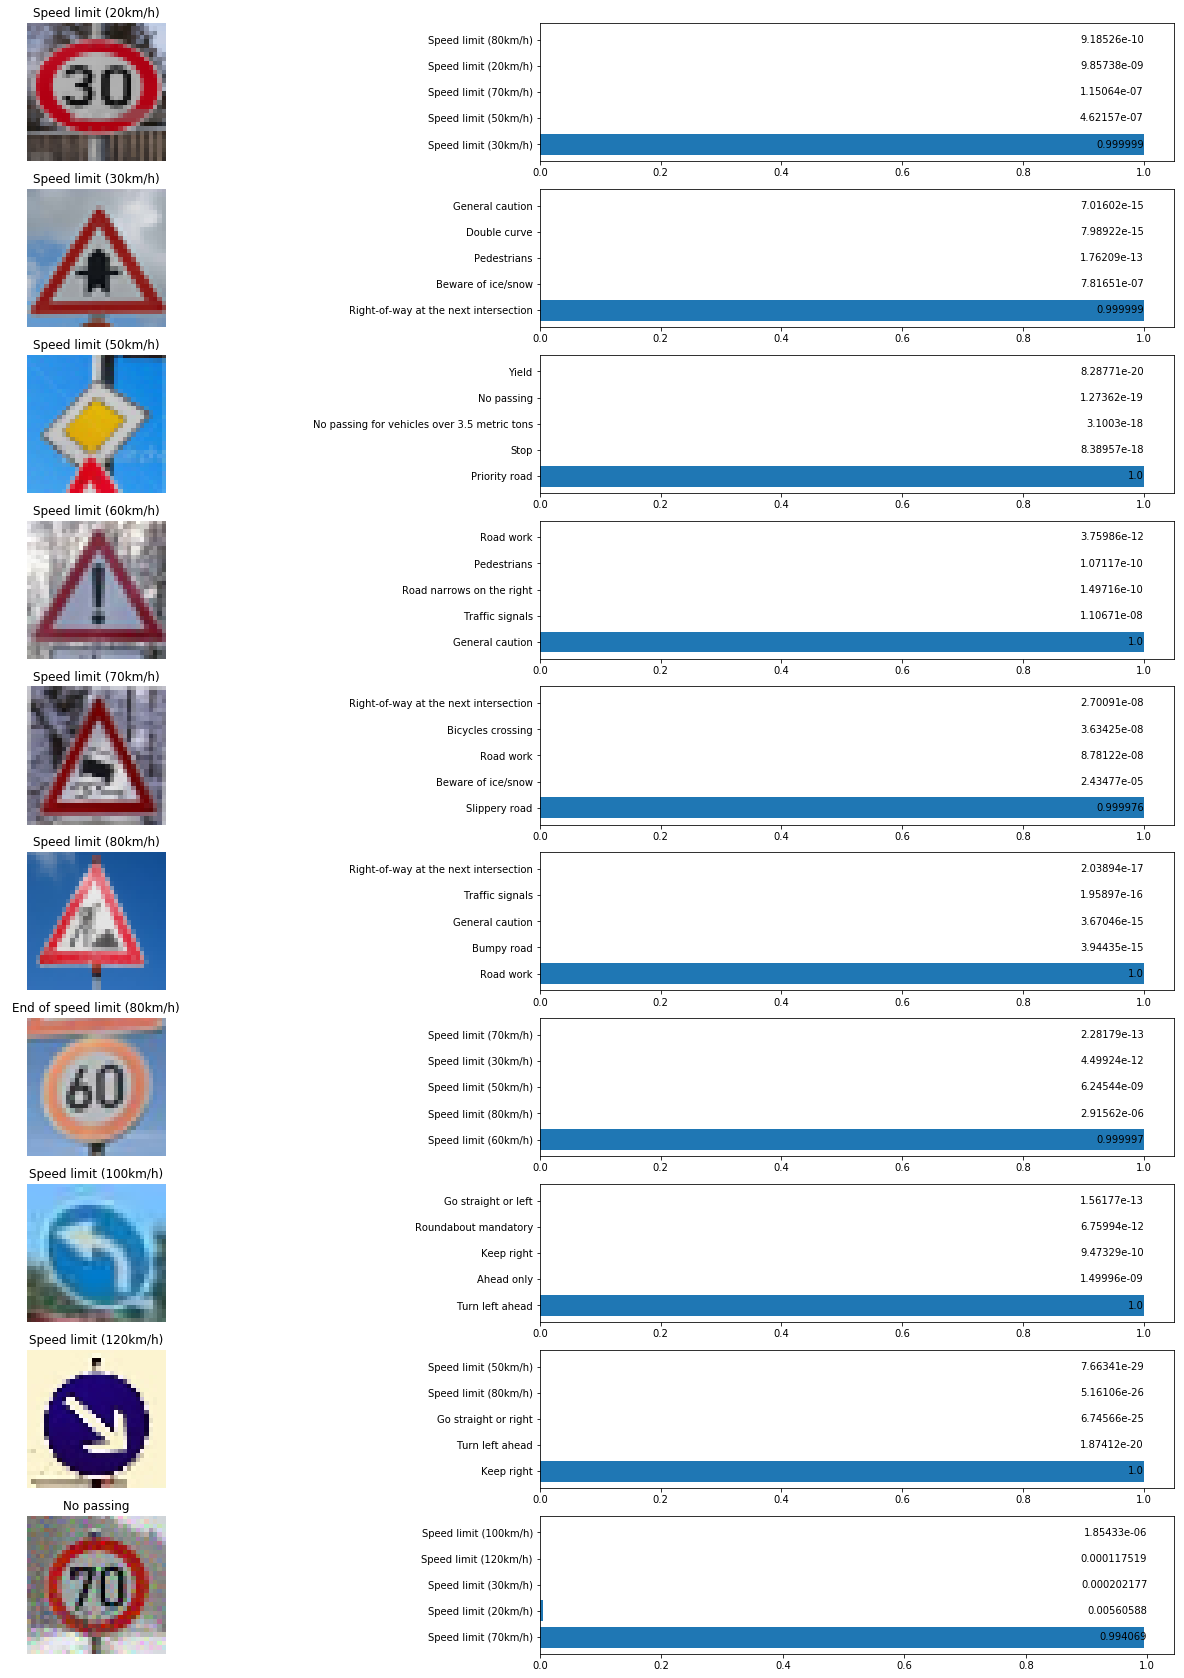

In [422]:
plot_cache = {"title": new_test_title
             , "feature":new_test_images_X
             , "label_pred":y_pred
             , "label_true":new_test_images_Y
             , "test_images":new_test_images}

plot_top_k_predition(plot_cache, 5)

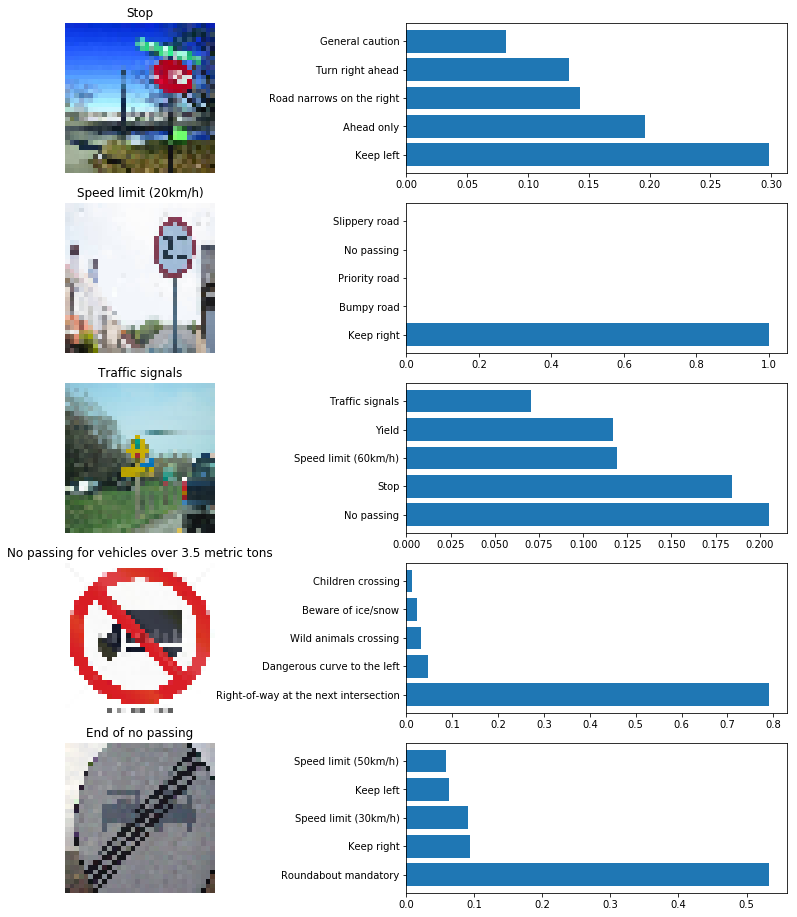

# Conclusion

When image is clear, the accuracy on test images is 


* the accuracy 
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Calculate and report the accuracy on the training and validation set.
Once a final model architecture is selected, 
the accuracy on the test set should be calculated and reported as well.


* test on image
download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

# Furture work

2  Step 4 (Optional): Visualize the Neural Network's State with Test Images
This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the LeNet lab's feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper End-to-End Deep Learning for Self-Driving Cars in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# Importing a pre-trained model

## Create the network
`import_meta_graph` loads the network defined in `.meta` file to the current graph, so,this will create the graph/network. After that, we still need to load the pretrained parameters on this graph.

ex: 
```python
saver = tf.train.import_meta_graph('my_test_model-1000.meta')
```

## Load the parameters
We can restore the parameters of the network by calling restore on this saver which is an instance of `tf.train.Saver()` class.

Once you can restore any pre-trained model, you can do fine-tuning, transfer learning or further training.

There is only one checkpoint. If you build another model, the checkpoint file will be overwritten. Each model should be saved in its own direcotry 